<a href="https://colab.research.google.com/github/SamuelBM21/IC/blob/main/ECGCategorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch                        #PyTorch
import torch.nn as nn               #Camadas da Rede neural
import torch.optim as optim         #Otimizadores
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/DataSets/mitbih_train.csv',header=None)
df_test = pd.read_csv('/content/drive/MyDrive/DataSets/mitbih_test.csv',header=None)

In [ ]:
X_train = df_train.iloc[:, :-1].values.astype(np.float32)           #A última coluna possui os labels.
y_train = df_train.iloc[:, -1].values.astype(np.int64)

X_test = df_test.iloc[:, :-1].values.astype(np.float32)
y_test = df_test.iloc[:, -1].values.astype(np.int64)


In [ ]:
#Class DataSet Pytorch

class ECGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X).unsqueeze(1)  # [N, 1, 187]
        self.y = torch.tensor(y).long()       # [N, num_classes]

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
batch_size = 64
learning_rate = 0.001
epochs = 25

conditions = {
    0: "Normal (N)",
    1: "Supraventricular premature (S)",
    2: "Premature ventricular contraction (V)",
    3: "Fusion of ventricular and normal beat (F)",
    4: "Unclassifiable beat (Q)"
}

train_dataset = ECGDataset(X_train, y_train)
test_dataset = ECGDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class ECG_CNN(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=7, padding=3),   # [B, 32, 187]
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),                              # [B, 32, 93]

            nn.Conv1d(32, 64, kernel_size=5, padding=2),  # [B, 64, 93]
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),                              # [B, 64, 46]

            nn.Conv1d(64, 128, kernel_size=3, padding=1), # [B, 128, 46]
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),                              # [B, 128, 23]

            nn.Conv1d(128, 256, kernel_size=3, padding=1),# [B, 256, 23]
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(2)                               # [B, 256, 11]
        )

        self.fc_layer = nn.Sequential(
            nn.Flatten(),                      # [B, 256*11]
            nn.Linear(256 * 11, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)        # saída = 5 classes
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = self.fc_layer(x)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ECG_CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

In [ ]:
def train_model(model, train_loader, criterion, optimizer, device, epochs=10):
    model.to(device)
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f"Época {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")

In [ ]:
def test_model(model, test_loader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            true_labels = labels # Use the labels directly as they are already class indices

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(true_labels.cpu().numpy())

    print("\n Classification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

In [ ]:
def plot_prediction(df_test, index, model, device, class_names):
    # Extrai o sinal e o rótulo verdadeiro
    row = df_test.iloc[index, :187].values.astype(np.float32)
    true_label = int(df_test.iloc[index, 187])

    # Prepara para o modelo
    signal_tensor = torch.tensor(row).unsqueeze(0).unsqueeze(0).to(device)  # shape: [1, 1, 187]

    model.eval()
    with torch.no_grad():
        output = model(signal_tensor)
        pred_label = torch.argmax(output, dim=1).item()

    # Nome das classes
    true_name = class_names[true_label]
    pred_name = class_names[pred_label]

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(row, color='black', linewidth=1.5)
    plt.title(f"ECG Signal | True: {true_name} | Predicted: {pred_name}", fontsize=14)
    plt.xlabel("Time (ms)", fontsize=12)
    plt.ylabel("Amplitude (mV)", fontsize=12)
    plt.grid(which='both', linestyle='--', linewidth=0.5, color='red', alpha=0.3)
    plt.minorticks_on()
    plt.tight_layout()
    plt.show()

In [ ]:
train_model(model,train_loader,criterion,optimizer,device,epochs)

Época 1/25 - Loss: 0.1418
Época 2/25 - Loss: 0.0836
Época 3/25 - Loss: 0.0675
Época 4/25 - Loss: 0.0577
Época 5/25 - Loss: 0.0523
Época 6/25 - Loss: 0.0464
Época 7/25 - Loss: 0.0417
Época 8/25 - Loss: 0.0392
Época 9/25 - Loss: 0.0349
Época 10/25 - Loss: 0.0347
Época 11/25 - Loss: 0.0325
Época 12/25 - Loss: 0.0291
Época 13/25 - Loss: 0.0259
Época 14/25 - Loss: 0.0253
Época 15/25 - Loss: 0.0243
Época 16/25 - Loss: 0.0227
Época 17/25 - Loss: 0.0219
Época 18/25 - Loss: 0.0202
Época 19/25 - Loss: 0.0192
Época 20/25 - Loss: 0.0200
Época 21/25 - Loss: 0.0180
Época 22/25 - Loss: 0.0169
Época 23/25 - Loss: 0.0168
Época 24/25 - Loss: 0.0174
Época 25/25 - Loss: 0.0165



 Classification Report:

                                           precision    recall  f1-score   support

                               Normal (N)       1.00      1.00      1.00     72471
           Supraventricular premature (S)       0.99      0.94      0.97      2223
    Premature ventricular contraction (V)       1.00      0.98      0.99      5788
Fusion of ventricular and normal beat (F)       0.92      0.87      0.90       641
                  Unclassifiable beat (Q)       1.00      1.00      1.00      6431

                                 accuracy                           1.00     87554
                                macro avg       0.98      0.96      0.97     87554
                             weighted avg       1.00      1.00      1.00     87554



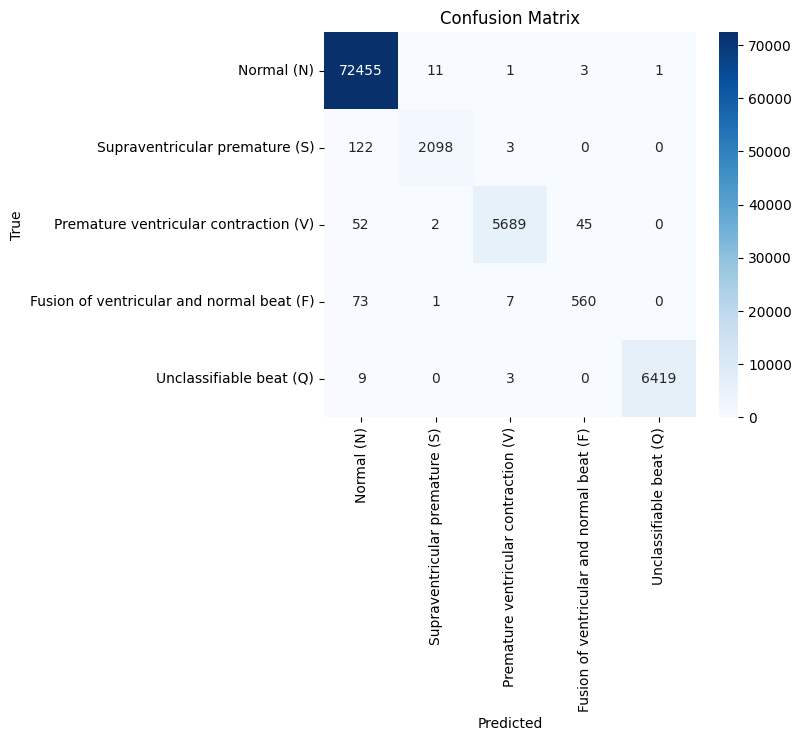

In [ ]:
test_model(model, train_loader, device, list(conditions.values()))


 Classification Report:

                                           precision    recall  f1-score   support

                               Normal (N)       0.99      1.00      0.99     18118
           Supraventricular premature (S)       0.93      0.76      0.84       556
    Premature ventricular contraction (V)       0.98      0.94      0.96      1448
Fusion of ventricular and normal beat (F)       0.82      0.77      0.80       162
                  Unclassifiable beat (Q)       1.00      0.99      0.99      1608

                                 accuracy                           0.99     21892
                                macro avg       0.94      0.89      0.92     21892
                             weighted avg       0.99      0.99      0.99     21892



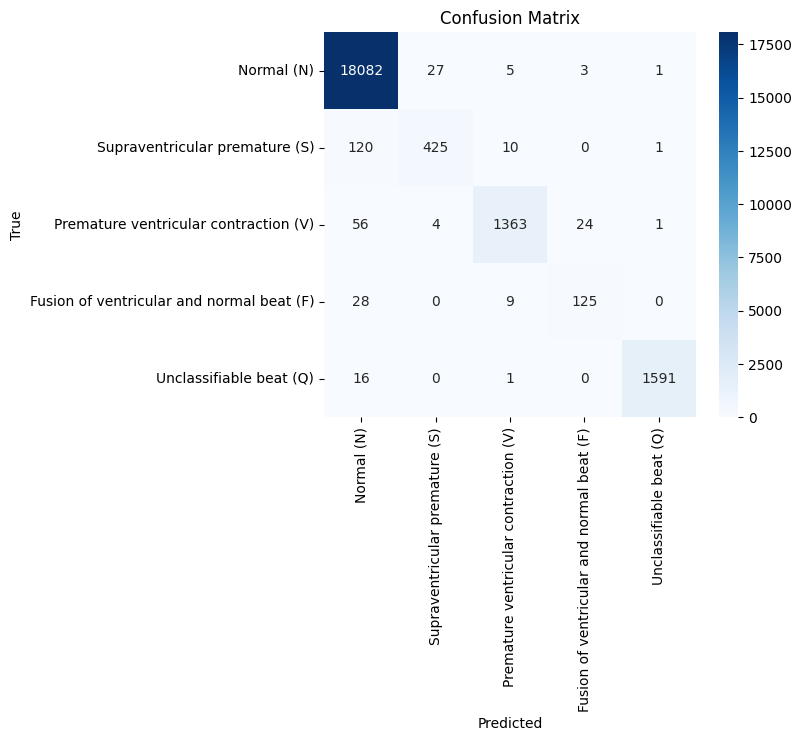

In [ ]:
test_model(model, test_loader, device, list(conditions.values()))

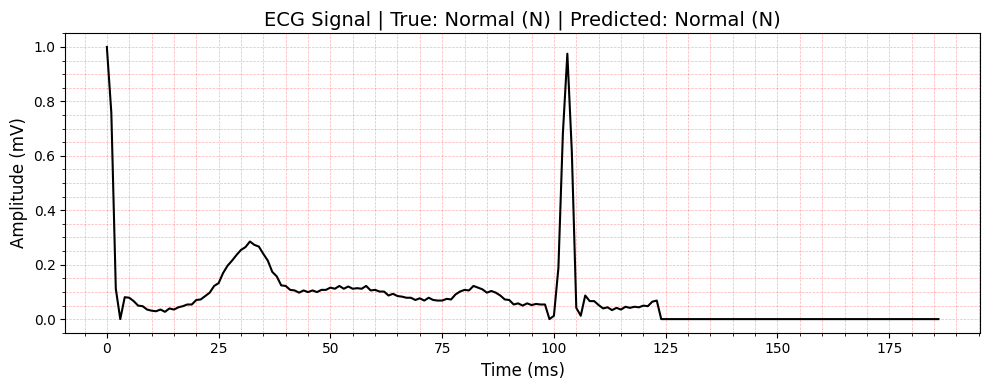

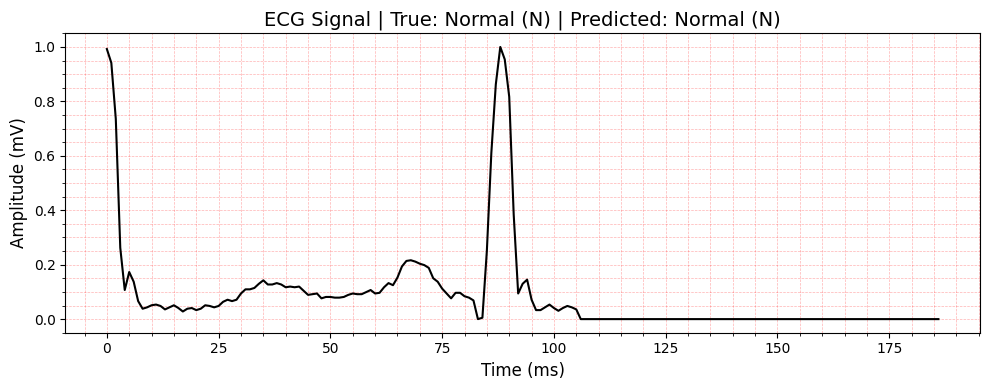

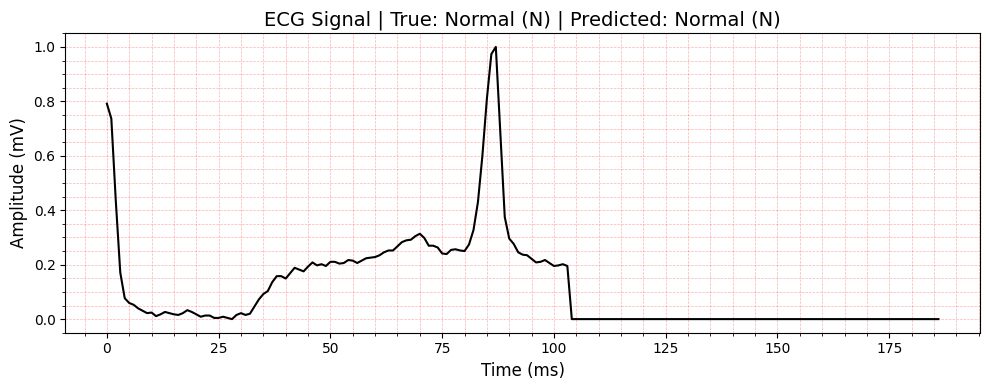

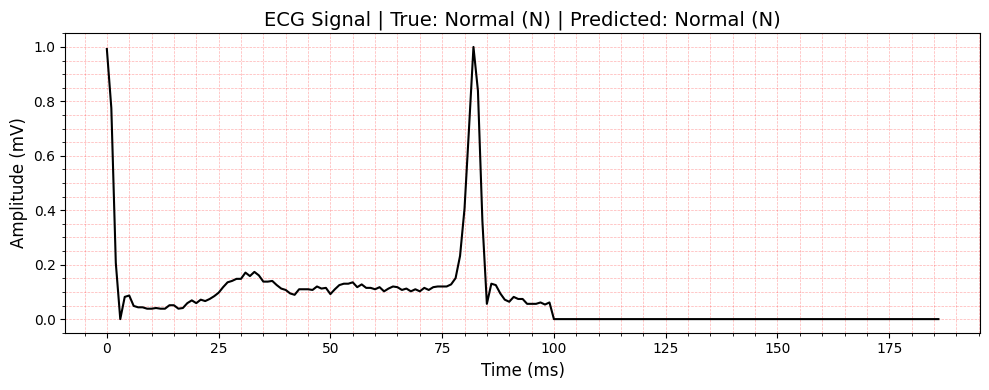

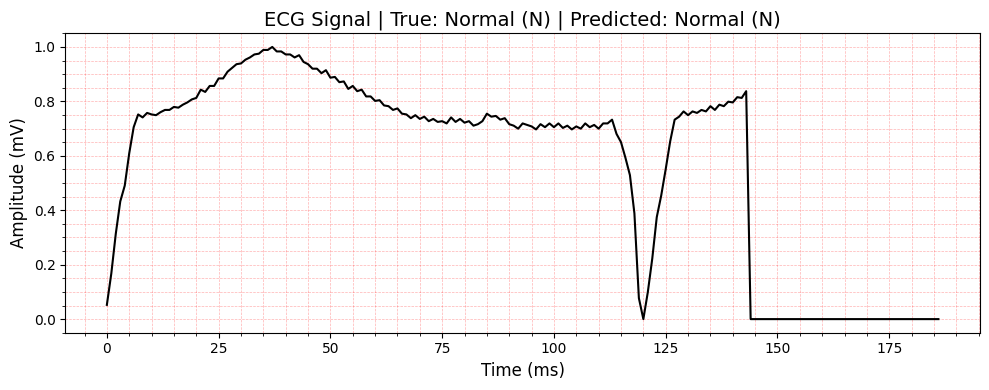

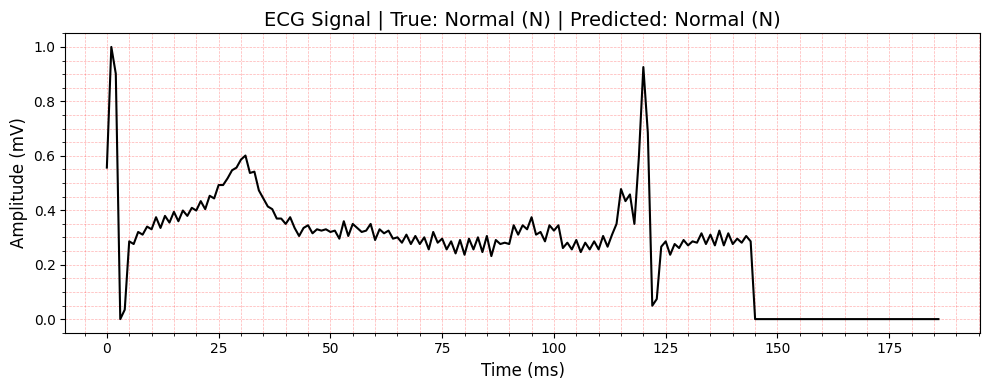

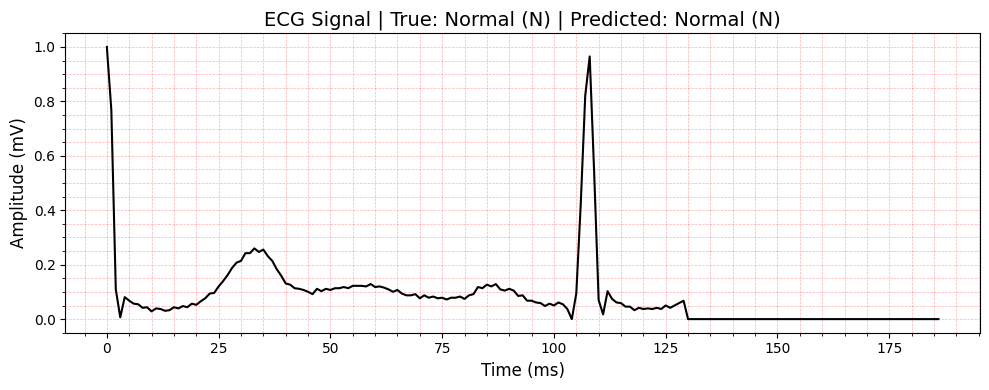

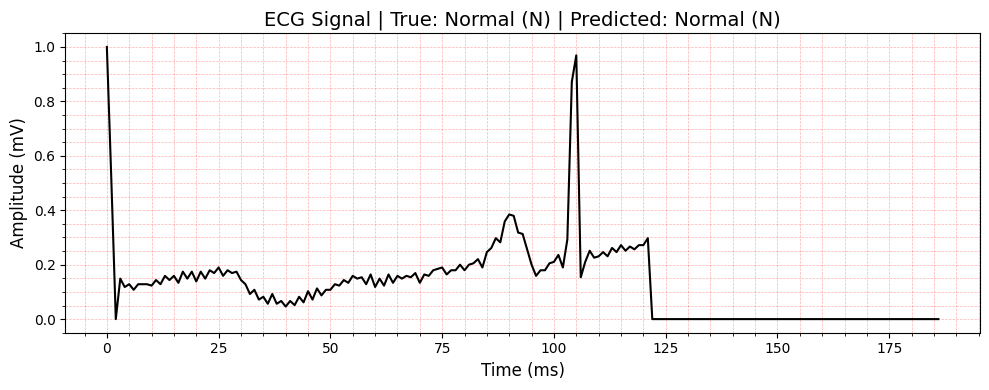

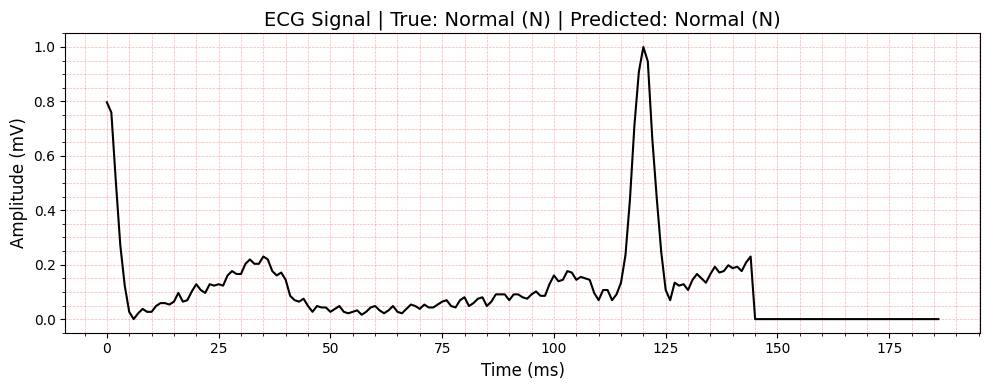

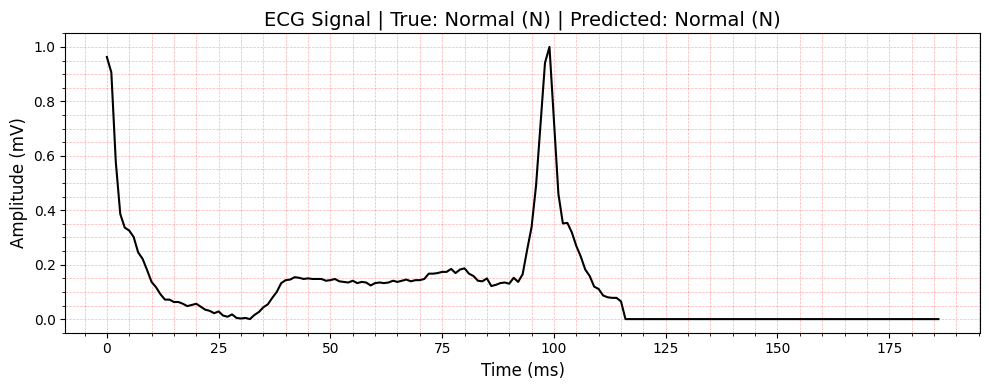

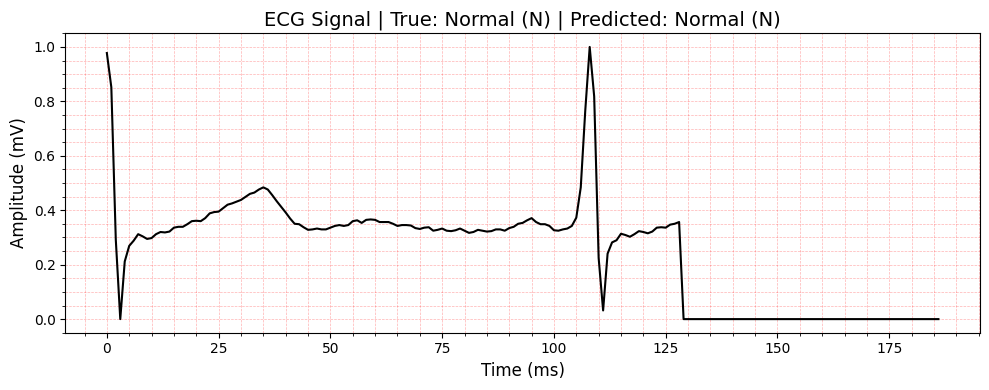

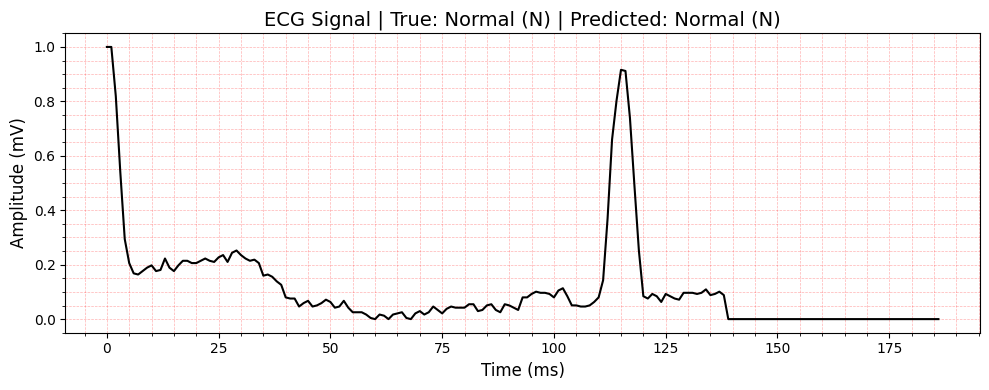

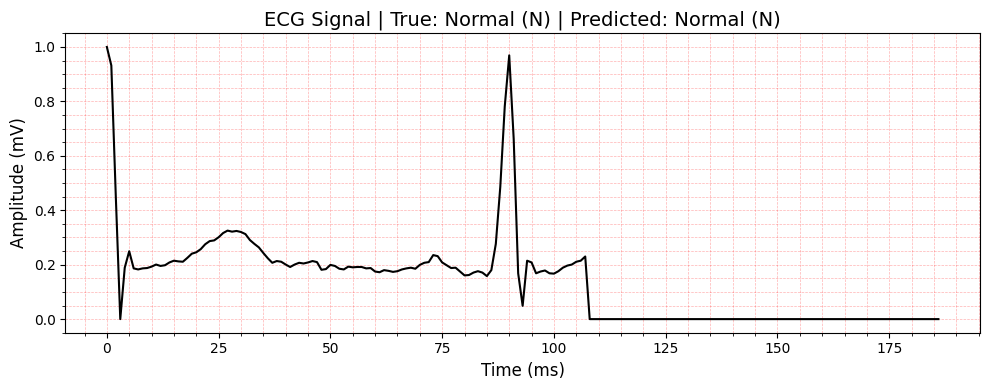

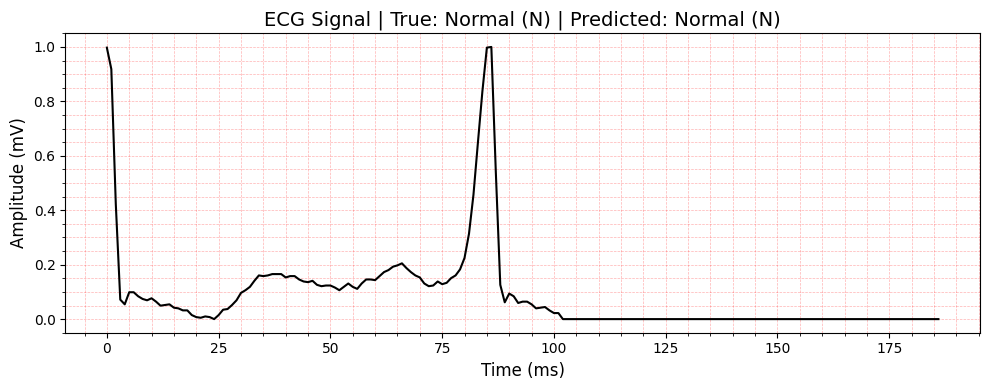

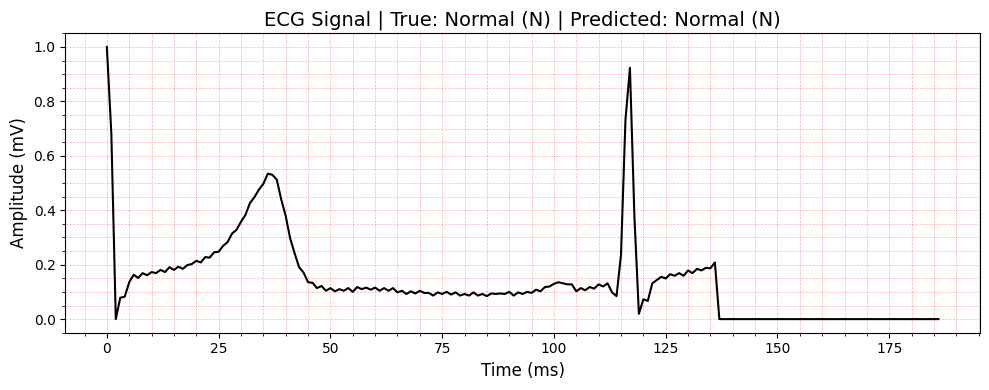

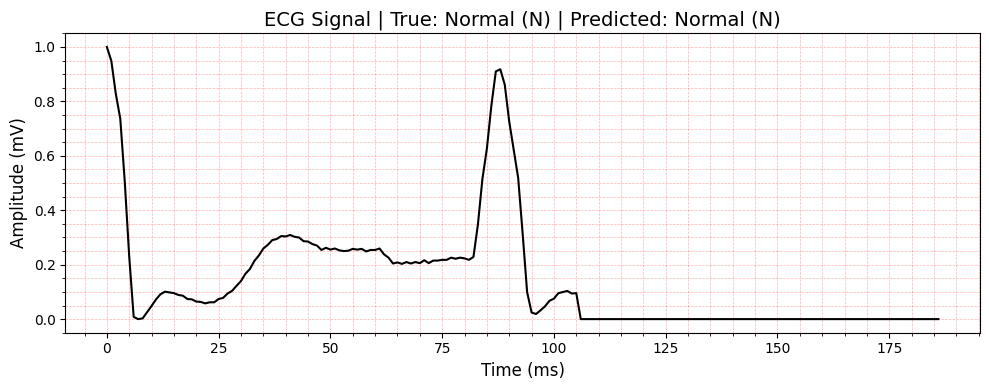

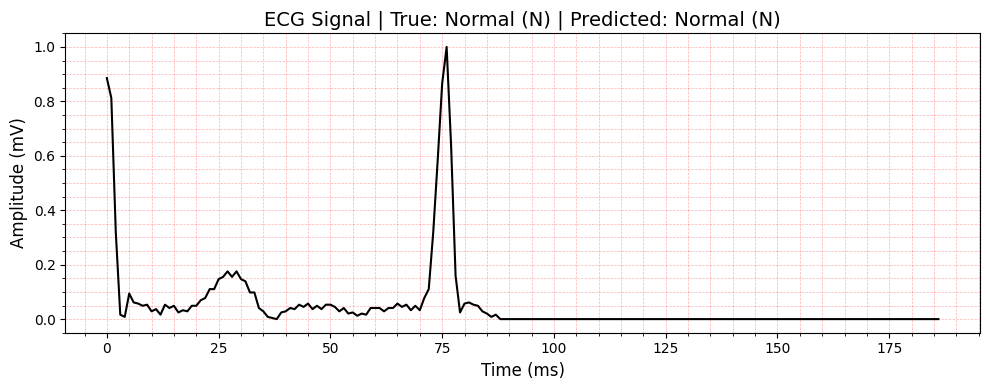

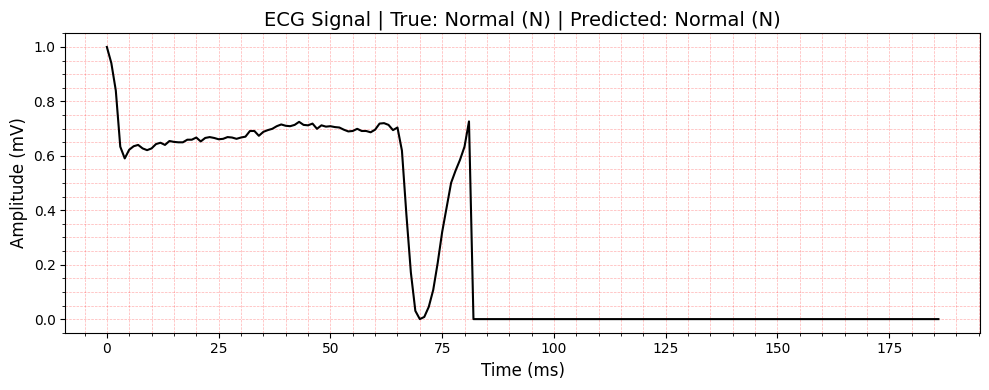

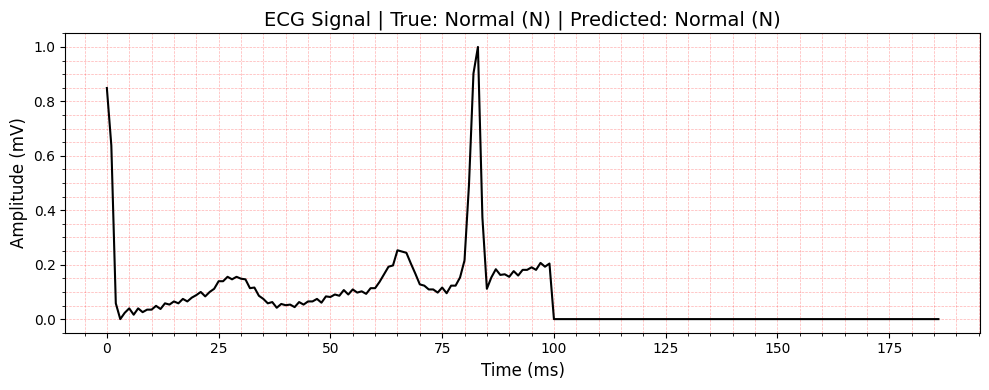

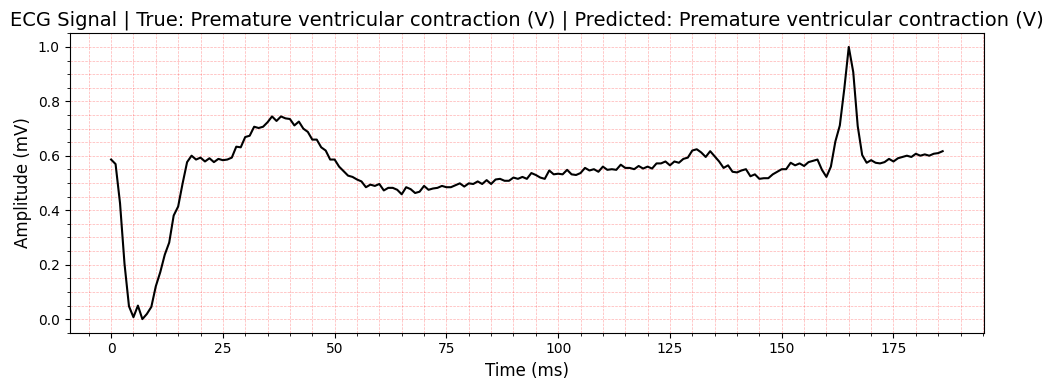

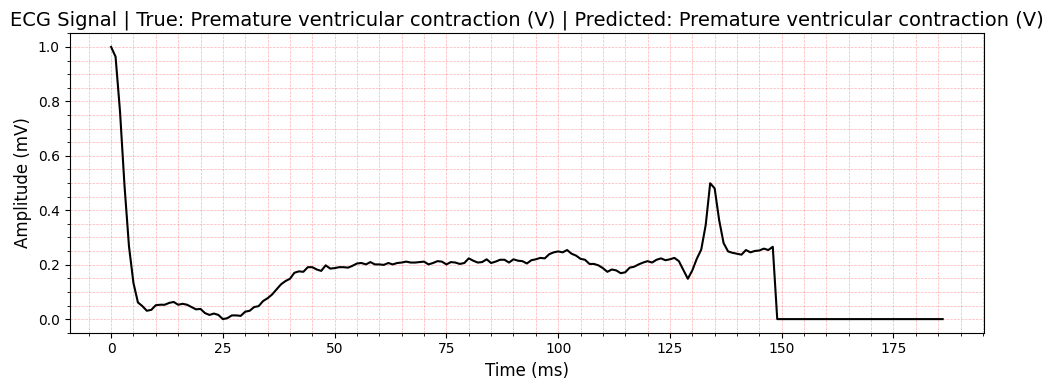

In [ ]:
for i in range (0, 20001, 1000):
    plot_prediction(df_test,i,model, device, list(conditions.values()))